In [1]:
from fastcore.transform import *
from fastai.data.all import *
from fastai.vision.all import *
import pandas as pd
from pathlib import Path
from nbdev import show_doc
from IPython.core.debugger import set_trace
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
import os

In [2]:
def get_y(o): 
    _,_,_,_,dx,dy=df.iloc[int(o.parts[-1].split('.')[0])]
    return [[dx, dy, 400+dx, 400+dy]]
def get_label(noop): return [None]

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
df = pd.read_csv('annotations.csv')

In [5]:
gen_url = Path(os.environ['HOME'] + "/.fastai/data/chess_screenshots2")

In [6]:
block = DataBlock(
    blocks=(ImageBlock, BBoxBlock, BBoxLblBlock), 
    get_items=get_image_files, 
    get_y=[get_y, get_label],
    n_inp=1,
    item_tfms=[Resize(224)])
block.c=1

In [7]:
dls=block.dataloaders(gen_url, batch_size=64)

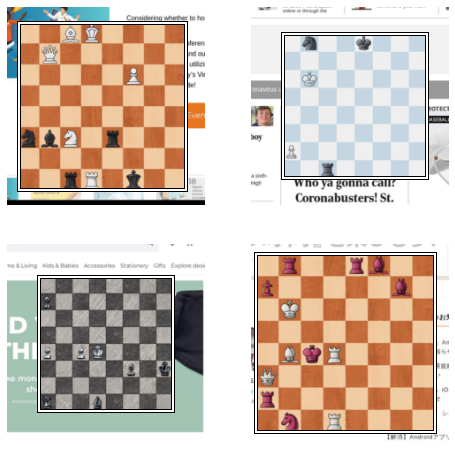

In [8]:
dls.show_batch(max_n=4, figsize=(8, 8))

In [24]:
resnet34(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  